In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import models.model_picker as mp
import params.param_picker as pp
import utils.plot_functions as pf
from data.nat_dataset import Dataset

In [2]:
vals_norm = np.load("Resistance_Program_Log_Norm.npz")
vals = np.load("Resistance_Program_Log.npz")

In [3]:
#for i in range(3):
#    res = vals['arr_'+str(i)]
#    plt.hist(res.flatten())
#    plt.show()

In [4]:
#for i in range(3):
#    res = vals_norm['arr_'+str(i)]
#    plt.hist(res.flatten())
#    plt.show()

In [5]:
weight_locs = ["/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/b3.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/b4.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/b5.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/b_gdn3.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/b_gdn4.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/b_gdn5.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/w3.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/w4.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/w5.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/w_gdn3.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/w_gdn4.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/w_gdn5.npz"]
weights = [np.load(file)["data"] for file in weight_locs]

In [6]:
def normalizer(x, x_max, x_min, new_min, new_max): 
  return (((x-x_min)/(x_max-x_min))*(new_max-new_min)+new_min)

In [7]:
##### R2 is the value provided by Dylan #####
R2 = np.load("/home/dpaiton/image_rram_encoding.npz")["data"].reshape(-1)

##### R3 is the target resistance value written to array #####
R3 = normalizer(R2, 1, -1, 4, 8)

##### R4 is predicted measured log(resistance) of array #####
R4 = np.zeros(448)
for ii in np.arange(448):
  R4[ii] = np.random.uniform(R3[ii] - 0.5*np.log(2), R3[ii] + 0.5*np.log(2))

##### R5 is value mapped back to network from measured data #####
R5 = normalizer(R4, 8, 4, -0.35, 0.35)

#### R6 is a corrupted version of R5 ####
indices = np.random.permutation(448)
num_corrupted = 67
corrupt_indices = indices[0:num_corrupted]
R6 = R4.copy()
R6[corrupt_indices] = 3+4*np.random.rand(num_corrupted)
R6 = normalizer(R6, 8, 4, -0.35, 0.35)

In [8]:
vmin = -1.00
vmax = 1.00

res_rram = vals["arr_1"]
#res_rram[res_rram<-1] = -1
res_rram = normalizer(res_rram, np.amin(res_rram), np.amax(res_rram), vmin, vmax)

res_nosig = np.squeeze(np.load("/home/dpaiton/u.npz")["data"])

res_sig = np.squeeze(np.load("/home/dpaiton/u_sig.npz")["data"])

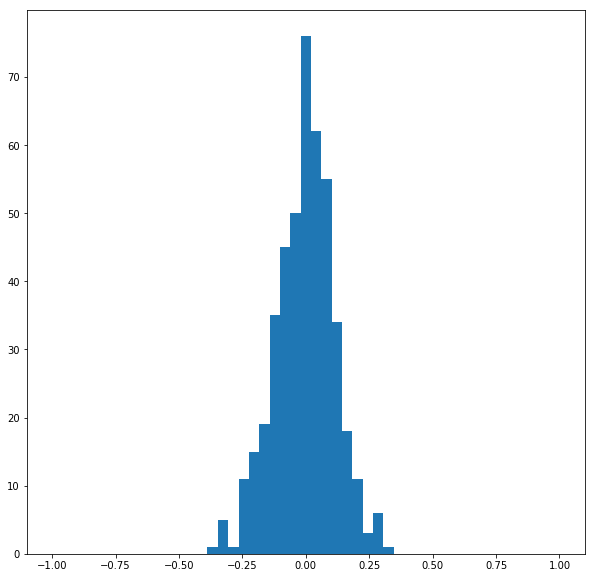

In [26]:
fig, ax = plt.subplots(1, figsize=(10,10))
bins = np.linspace(vmin,vmax, num_bins)
ax.hist(res_nosig.flatten(), bins)
plt.show()

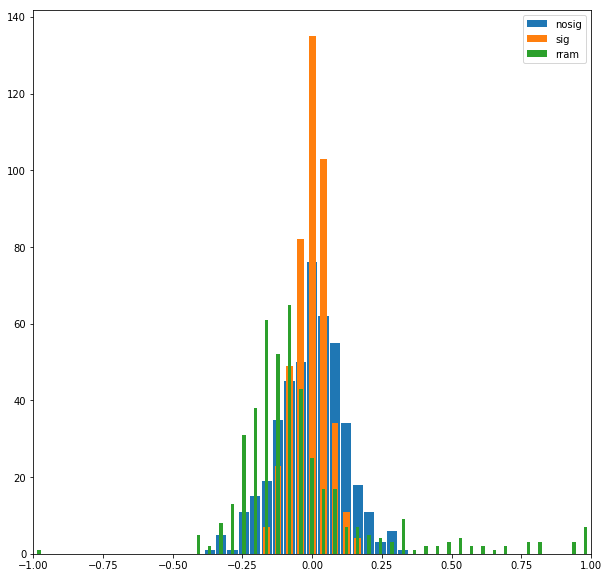

In [27]:
num_bins = 50
bins = np.linspace(vmin,vmax, num_bins)

fig, ax = plt.subplots(1, figsize=(10,10))
ax.hist(res_nosig.flatten(), bins, rwidth=0.9, align='mid', label='nosig')
ax.hist(res_sig.flatten(), bins, rwidth=0.6, align='mid', label='sig')
ax.hist(res_rram.flatten(), bins, rwidth=0.3, align='mid', label='rram')
ax.set_xlim([-1,1])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.show()

In [66]:
model_type = "conv_gdn_decoder"
## Import params
params, schedule = pp.get_params(model_type)
params["batch_size"] = 5
## Import model
model = mp.get_model(model_type)
model.setup(params, schedule)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config, graph=model.graph) as sess:
  # Need to provide shape if batch_size is used in graph
  feed_dict={model.x:np.zeros([model.batch_size]+model.input_shape, dtype=np.float32)}
  for idx, b_array in enumerate(weights[0:3]):
    feed_dict[model.b_init_list[idx]] = b_array
  for idx, b_igdn_array in enumerate(weights[3:6]):
    feed_dict[model.b_igdn_init_list[idx]] = b_igdn_array
  for idx, w_array in enumerate(weights[6:9]):
    feed_dict[model.w_init_list[idx]] = w_array
  for idx, w_igdn_array in enumerate(weights[9:]):
    feed_dict[model.w_igdn_init_list[idx]] = w_igdn_array
  sess.run(model.init_op, feed_dict=feed_dict)
  feed_dict[model.x] = np.stack([res_nosig, res_sig, res_rram, R5.reshape((8,8,7)), R6.reshape((8,8,7))], axis=0)
  recon_nosig, recon_sig, recon_rram, recon_r5, recon_r6 = sess.run(model.u_list[-1], feed_dict)


06/29/18 15:41:54 -- <params>{
  "b_thresh_min": 0.001,
  "batch_size": 5,
  "data_dir": "/home/dpaiton/Work/Datasets/",
  "data_file": "/media/tbell/datasets/verified_images.txt",
  "device": "/gpu:0",
  "eps": 1e-12,
  "gdn_mult_min": 1e-06,
  "input_channels": [
    7,
    128,
    128
  ],
  "input_shape": [
    8,
    8,
    7
  ],
  "model_name": "conv_gdn_decoder",
  "model_type": "conv_gdn_decoder",
  "out_dir": "/home/dpaiton/Work/Projects/",
  "output_channels": [
    128,
    128,
    1
  ],
  "patch_size_x": [
    5,
    5,
    9
  ],
  "patch_size_y": [
    5,
    5,
    9
  ],
  "rand_seed": 1234567890,
  "strides": [
    2,
    2,
    4
  ],
  "version": "0.0",
  "w_thresh_min": 0.001
}</params>

06/29/18 15:41:54 -- <schedule>null</schedule>


In [67]:
input_file = "/home/dpaiton/tmp_file_loc.txt"
data_params = {}
data_params["rand_state"] = np.random.RandomState(1)
data_params["data_shape"] = [128,128,1]
data = {"train": Dataset(input_file, data_params)}
data_batch = data["train"].next_batch(model.batch_size)
input_data = data_batch[0][0,...]

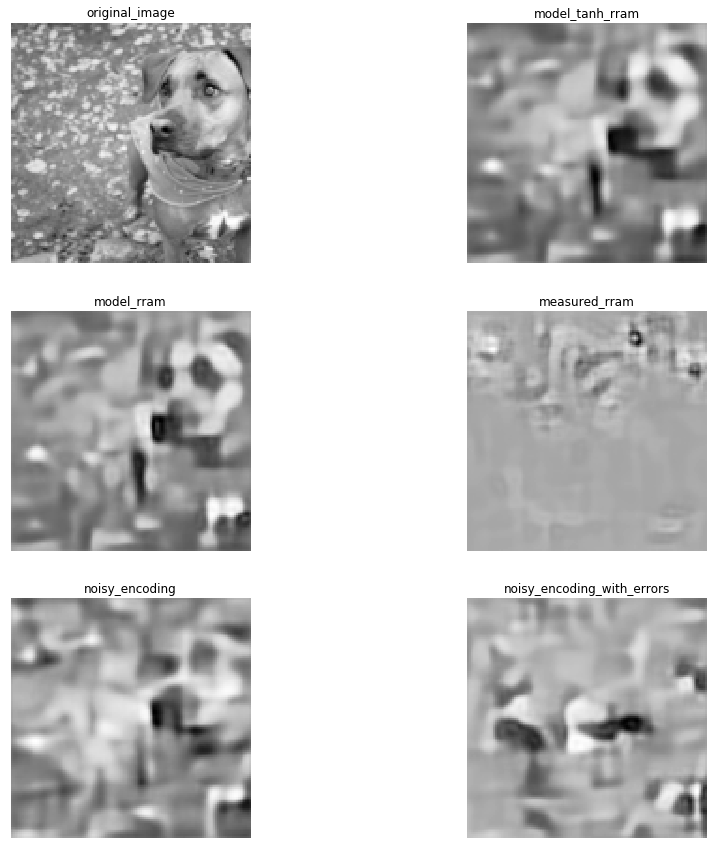

In [68]:
fig, ax = plt.subplots(3,2, figsize=(15,15))
ax[0,0] = pf.clear_axis(ax[0,0])
ax[0,0].imshow(np.squeeze(input_data), cmap="Greys_r")
ax[0,0].set_title("original_image")

ax[0,1] = pf.clear_axis(ax[0,1])
ax[0,1].imshow(np.squeeze(recon_sig), cmap="Greys_r")
ax[0,1].set_title("model_tanh_rram")

ax[1,0] = pf.clear_axis(ax[1,0])
ax[1,0].imshow(np.squeeze(recon_nosig), cmap="Greys_r")
ax[1,0].set_title("model_rram")

ax[1,1] = pf.clear_axis(ax[1,1])
ax[1,1].imshow(np.squeeze(recon_rram), cmap="Greys_r")
ax[1,1].set_title("measured_rram")

ax[2,0] = pf.clear_axis(ax[2,0])
ax[2,0].imshow(np.squeeze(recon_r5), cmap="Greys_r")
ax[2,0].set_title("noisy_encoding")

ax[2,1] = pf.clear_axis(ax[2,1])
ax[2,1].imshow(np.squeeze(recon_r6), cmap="Greys_r")
ax[2,1].set_title("noisy_encoding_with_errors")
plt.show()